In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator

from pathlib import Path
from MITRotor import BEM, IEA10MW, IEA15MW, BEMGeometry, AerodynamicProperties, NoTipLoss, PrandtlTipLoss, ConstantInduction, KraghAerodynamics, ClassicalMomentum, UnifiedMomentum, MadsenMomentum, NoTangentialInduction, DefaultTangentialInduction, BEMSolution


In [2]:
# # plt.style.use('/anvil/scratch/x-smata/postprocessing/scripts/figures_layout.mplstyle')
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [3]:
ref = 6

In [4]:
def per_error(A, E):
    error = ((A - E) / E) * 100

    return error

def interp_polars(r,t,R,T,data):
    interpolator = RegularGridInterpolator(
        (r, t), 
        data, 
        bounds_error=False, 
        fill_value=None  # Enables extrapolation
    )

    # Interpolation points
    points_new = np.column_stack((R.ravel(), T.ravel()))

    # Interpolate to new points
    return interpolator(points_new).reshape(R.shape)

In [5]:
# Get positive veers

# casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']
# casenames = [r's0_vn4', r's2_vn2', r's0_vn2',r'sn2_vn2', r's4_v0', r's2_v0', r's0_v0', r'sn2_v0', r'sn4_v0', r's2_v2', r's0_v2', r'sn2_v2', r's0_v4']
casenames = [r's0_vn4', r'sn2_vn2', r's0_vn2',r's2_vn2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_v2', r's0_v2', r's2_v2', r's0_v4']

wrfles_data = []
for count, name in enumerate(casenames):
    wrfles_data.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/old_clockwise/gad_sweep/'+casenames[count]+'.npz')))

In [6]:
ind_fields = {}

for count, name in enumerate(casenames):

    y = (wrfles_data[count]['Y3'] - wrfles_data[count]['rotor_yloc'])/(wrfles_data[count]['diameter']/2)
    z = (wrfles_data[count]['Z3'] - wrfles_data[count]['hub_height'])/(wrfles_data[count]['diameter']/2)

    r     = (y**2 + z**2)**(1/2)
    theta = np.arctan2(y,z)

    wsn4  = ((np.mean(wrfles_data[count]['ux_n4D'], axis=0)**2 + np.mean(wrfles_data[count]['vx_n4D'], axis=0)**2)**(1/2) / wrfles_data[count]['uinf'])
    wdn4  = (np.arctan2(np.mean(wrfles_data[count]['vx_n4D'], axis=0), np.mean(wrfles_data[count]['ux_n4D'], axis=0)))

    ws  = ((np.mean(wrfles_data[count]['ux_0D'], axis=0)**2 + np.mean(wrfles_data[count]['vx_0D'], axis=0)**2)**(1/2) / wrfles_data[count]['uinf'])
    wd  = (np.arctan2(np.mean(wrfles_data[count]['vx_0D'], axis=0), np.mean(wrfles_data[count]['ux_0D'], axis=0)))

    ind_fields[count] = 1 - ws / wsn4

In [7]:
del wrfles_data

In [8]:
# Get s0_v4 
casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']

# wrfles_data.reverse()

wrfles_data = []
for count, name in enumerate(casenames):
    wrfles_data.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/old_clockwise/gad_sweep/'+casenames[count]+'.npz')))

In [9]:
wrf_ind = np.zeros(len(casenames))
mit_ind = np.zeros(len(casenames))

wrf_thr = np.zeros(len(casenames))
mit_thr = np.zeros(len(casenames))

wrf_pow = np.zeros(len(casenames))
mit_pow = np.zeros(len(casenames))

In [10]:
for count in range(len(casenames)):

    y = (wrfles_data[count]['Y3'] - wrfles_data[count]['rotor_yloc'])/(wrfles_data[count]['diameter']/2)
    z = (wrfles_data[count]['Z3'] - wrfles_data[count]['hub_height'])/(wrfles_data[count]['diameter']/2)

    r     = (y**2 + z**2)**(1/2)
    theta = np.arctan2(y,z)

    ws  = ((np.mean(wrfles_data[count]['ux_n4D'], axis=0)**2 + np.mean(wrfles_data[count]['vx_n4D'], axis=0)**2)**(1/2) / wrfles_data[count]['uinf']) * (1 - ind_fields[count])
    wd  = (np.arctan2(np.mean(wrfles_data[count]['vx_n4D'], axis=0), np.mean(wrfles_data[count]['ux_n4D'], axis=0)))

    ct  = np.mean(wrfles_data[count]['ct'],  axis=0)
    cp  = np.mean(wrfles_data[count]['cp'],  axis=0)
    cl  = np.mean(wrfles_data[count]['cl'],  axis=0)
    cd  = np.mean(wrfles_data[count]['cd'],  axis=0)
    aoa = np.mean(wrfles_data[count]['aoa'], axis=0)
    f   = np.mean(wrfles_data[count]['f'],   axis=0)
    fn  = np.mean(wrfles_data[count]['fn'],  axis=0)
    ft  = np.mean(wrfles_data[count]['ft'],  axis=0)
    vd  = np.mean(wrfles_data[count]['v1'],  axis=0)

    Ad = np.pi * (wrfles_data[count]['diameter']/2)**2

    # Mask points where r > R
    mask = r <= 1.5
    r_filtered     = r[mask]
    theta_filtered = theta[mask]
    ws_filtered    = ws[mask]
    wd_filtered    = wd[mask]

    # Interpolate to new polar grid
    r_new = np.linspace(0.0, 0.99999, 60)  # 50 points in r
    theta_new = np.linspace(0, 2 * np.pi, 360)  # 100 points in theta
    Theta_new, R_new = np.meshgrid(theta_new, r_new)

    # Convert new polar grid to Cartesian for interpolation
    X_new = R_new * np.sin(Theta_new)
    Y_new = R_new * np.cos(Theta_new)

    # Interpolate data to the new polar grid
    ws_rt = griddata(
        points=(y[mask], z[mask]),
        values=ws_filtered,
        xi=(X_new, Y_new),
        method='linear'
    )
    # Interpolate data to the new polar grid
    wd_rt = griddata(
        points=(y[mask], z[mask]),
        values=wd_filtered,
        xi=(X_new, Y_new),
        method='linear'
    )

    cl_r = wrfles_data[count]['rOverR']
    # cl_t = np.linspace(0, 2 * np.pi, 158) + np.pi/2
    cl_t = np.linspace(0, 2 * np.pi, 158)

    cl_T, cl_R = np.meshgrid(cl_t, cl_r)

    cl_x = cl_R * np.sin(cl_T)
    cl_y = cl_R * np.cos(cl_T)

    cl_r_new = np.linspace(0.0, 0.99999, 60)
    # cl_t_new = np.linspace(0, 2 * np.pi, 360) + np.pi/2
    cl_t_new = np.linspace(0, 2 * np.pi, 360)

    cl_T_new, cl_R_new = np.meshgrid(cl_t_new, cl_r_new)

    cl_x_new = cl_R_new * np.cos(cl_T_new)
    cl_y_new = cl_R_new * np.sin(cl_T_new)

    # Mask points where r > R
    mask = r <= 1.5
    r_filtered     = r[mask]
    theta_filtered = theta[mask]
    ws_filtered    = ws[mask]
    wd_filtered    = wd[mask]

    # Interpolate to new polar grid
    r_new = np.linspace(0.0, 1.05, 60)  # 50 points in r
    theta_new = np.linspace(0, 2 * np.pi, 360)  # 100 points in theta
    Theta_new, R_new = np.meshgrid(theta_new, r_new)

    # Convert new polar grid to Cartesian for interpolation
    X_new = R_new * np.sin(Theta_new)
    Y_new = R_new * np.cos(Theta_new)

    # Initialize rotor with increased radial resolution.
    rotor = IEA10MW()

    bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=60, Ntheta=360), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=ConstantInduction(), tangential_induction_model=NoTangentialInduction())

    pitch, tsr, yaw = np.deg2rad(0), 10.634, np.deg2rad(0.0)
    sol = bem(pitch, tsr, yaw, U=ws_rt, wdir=wd_rt)

    aoa_rt  = ws_rt * wrfles_data[count]['uinf'] * np.cos(wd_rt)

    wrf_ind[count] = 1/Ad * np.trapezoid(np.trapezoid((1- aoa_rt.T/wrfles_data[count]['uinf']) * cl_R_new[:,0] * (wrfles_data[count]['diameter']/2), cl_R_new[:,0] * (wrfles_data[count]['diameter']/2)), cl_T_new[0,:])
    mit_ind[count] = 1/Ad * np.trapezoid(np.trapezoid((1- (sol.U('sector') * np.cos(sol.wdir('sector'))).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)
    # mit_ind[count] = 1/Ad * np.trapezoid(np.trapezoid(((sol.a('sector')).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)

    # wrf_thr[count] = wrfles_data[count]['thrust'].mean()
    # mit_thr[count] = 1/Ad * np.trapezoid(np.trapezoid(((sol.Ct('sector')).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)

    wrf_thr[count] = wrfles_data[count]['thrust'].mean()
    # mit_thr = 1/Ad * np.trapezoid(np.trapezoid(((sol.Ct('sector')).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)
    mit_dT = (0.5 * 3 * 1.225 * rotor.chord_func(sol.geom.mu) * ((sol.W('sector') * 7)**2 * sol.Cax('sector')).T).T
    mit_thr[count] = np.trapezoid(np.trapezoid(mit_dT, sol.geom.theta), sol.geom.mu * rotor.R) / (2 * np.pi)

    wrf_pow[count] = wrfles_data[count]['power_aero'].mean()
    mit_dQ = (0.5 * 3 * 1.225 * rotor.chord_func(sol.geom.mu) * ((sol.W('sector') * 7)**2 * sol.Ctan('sector')).T) * sol.geom.mu * rotor.R
    mit_dP = mit_dQ * sol.tsr * 7 / rotor.R
    # mit_pow[count] = 1/Ad * np.trapezoid(np.trapezoid(((sol.Cp('sector')).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)
    mit_pow[count] = np.trapezoid(np.trapezoid(mit_dP.T, sol.geom.theta), sol.geom.mu * rotor.R) / (2 * np.pi)

/tmp/ipykernel_555512/4122025541.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  pow_levels = plt.cm.get_cmap('seismic', n_levels)  # Extract 13 colors from 'viridis'
/tmp/ipykernel_555512/4122025541.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  thr_levels = plt.cm.get_cmap('PiYG', n_levels)  # Extract 13 colors from 'viridis'
/tmp/ipykernel_555512/4122025541.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ind_levels = plt.cm.get_cmap('Spectral',

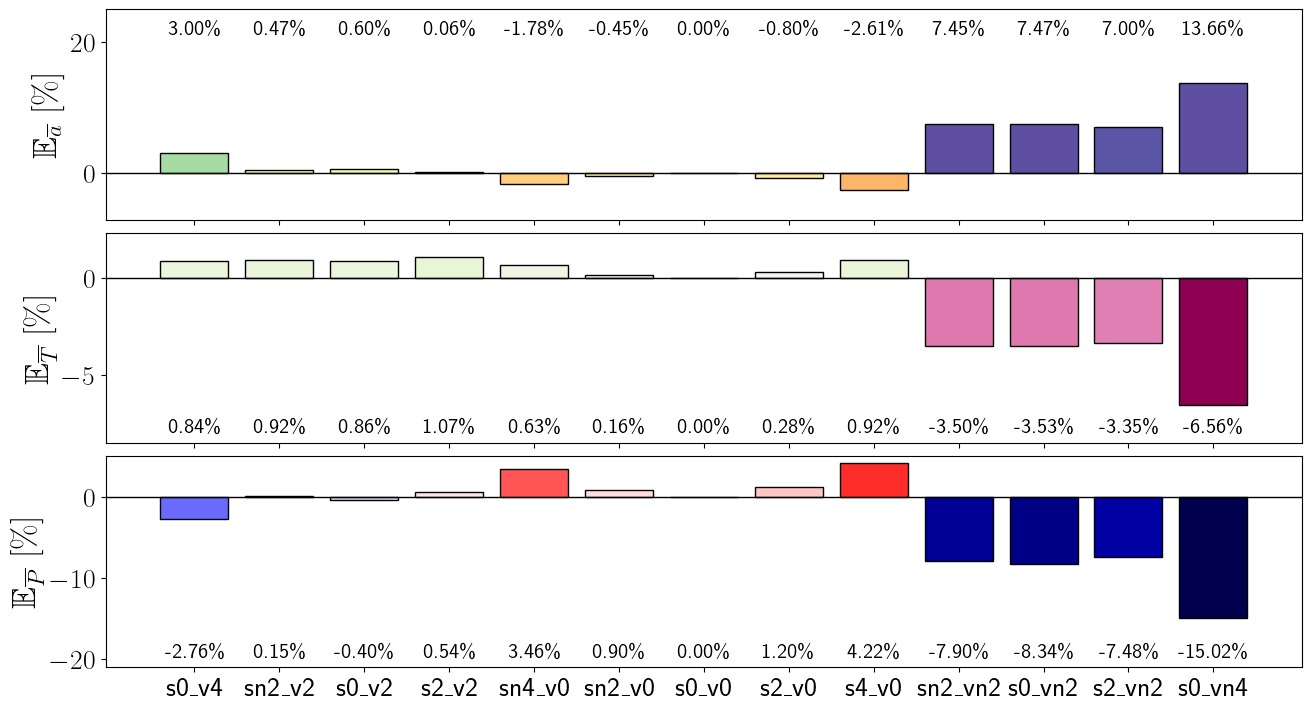

In [11]:
induction = per_error(mit_ind, mit_ind[ref])
thrust    = per_error(mit_thr, mit_thr[ref])
power     = per_error(mit_pow, mit_pow[ref])

n_levels = 100

pow_levels = plt.cm.get_cmap('seismic', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-10, vmax=10)  # Normalize power to [0, 1]
pow_cmap = [pow_levels(int(norm(p) * (n_levels - 1))) for p in power]  # Map power to discrete colors

thr_levels = plt.cm.get_cmap('PiYG', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-6, vmax=6)  # Normalize power to [0, 1]
thr_cmap = [thr_levels(int(norm(t) * (n_levels - 1))) for t in thrust]  # Map power to discrete colors

ind_levels = plt.cm.get_cmap('Spectral', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-7, vmax=7)  # Normalize power to [0, 1]
ind_cmap = [ind_levels(int(norm(a) * (n_levels - 1))) for a in induction]  # Map power to discrete colors


width = 0.75
alpha = 1.0

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(13, 7), sharex=True, constrained_layout = True)
ax[0].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[1].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[2].axhline(0, color='black', linestyle='solid', linewidth=1)
# ax[3].axhline(0, color='black', linestyle='solid', linewidth=1)

ind = np.arange(len(casenames))

for count in range(len(casenames)):

    # induction
    ax[0].bar(ind[count], induction[count], color=ind_cmap[count], edgecolor='black', alpha=alpha)
    ax[0].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{a}}~[\%]$', fontsize=fontsize)
    ax[0].text(ind[count], 21, f'{induction[count]:0.2f}\%', ha='center', fontsize=15)
    # ax[0].set_ylim([-4.5,18])
    ax[0].set_ylim([-7.2,25])

    # thrust
    ax[1].bar(ind[count], thrust[count], color=thr_cmap[count], edgecolor='black', alpha=alpha)
    ax[1].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{T}}~[\%]$', fontsize=fontsize)
    # ax[1].text(ind[count], -4.75, f'{thrust[count]}\%', ha='center', fontsize=15)
    # ax[1].set_ylim([-5,1.5])
    ax[1].text(ind[count], -8, f'{thrust[count]:0.2f}\%', ha='center', fontsize=15)
    ax[1].set_ylim([-8.5,2.3])

    # # torque
    # ax[2].bar(ind[count], wrfles_rel_diff_torque, color=colors[count], edgecolor='black', alpha=alpha)
    # ax[2].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{Q}}~[\%]$', fontsize=fontsize)
    # ax[2].text(ind[count], -8, f'{wrfles_rel_diff_torque[0]}\%', ha='center', fontsize=15)

    # power
    ax[2].bar(ind[count], power[count], color=pow_cmap[count], edgecolor='black', alpha=alpha)
    ax[2].set_xticks(ind)
    ax[2].set_xticklabels(casenames)
    ax[2].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{P}}~[\%]$', fontsize=fontsize)
    ax[2].text(ind[count], -20, f'{power[count]:0.2f}\%', ha='center', fontsize=15)
    # ax[2].set_ylim([-14,4])
    ax[2].set_ylim([-21,5])

plt.savefig("/scratch/09909/smata/wrf_les_sweep/runs/old_clockwise/gad_sweep/figs/mit_swap_ind_closure.png", bbox_inches="tight", dpi=800)
plt.show()